#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

#Data preparation

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
from matplotlib import pyplot as plt

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [3]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [4]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = [Y1_cat[num1],Y2_cat[num2]]

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [5]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: automobile, second = truck


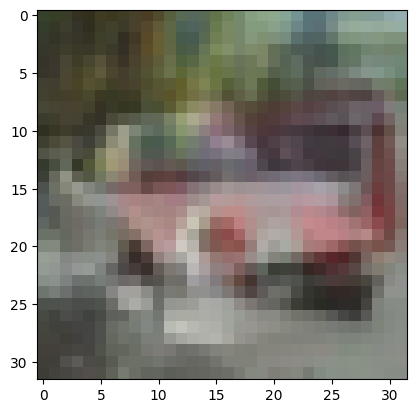

In [6]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [7]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [8]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [9]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [10]:
eval_model(random_model)

np.float64(0.2025)

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [11]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.19797
standard deviation =  0.002781294662562739


# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!



# MY PROPOSED SOLUTION
## STUDENT INFORMATIONS
Notaro Fabio, 0001126980, fabio.notaro2@studio.unibo.it
## KEY IDEA
Before arriving at the prposed solution, various approaches to the problem were explored, either using a single model or two combined, either by exploiting existing architectures (LeNet-5, ResNet, AlexNet and GoogleNet) or custom neural networks.

During the exploration of all of them, it emerged that the best results are obtained with a two-network approach.

The key idea of the presented solution is to split the problem into two sub-problems managed by separate neural networks, one for each half of the categories in the CIFAR-10 dataset.

In particular, the two neural networks are trained separately on images generated by randomly combining pairs of the different groups of categories:
* the first network is trained on mixed images to recognise only the first 5 classes (airplane, car, bird, cat, deer)
* the second network, similarly, is trained on the same combined images, but tries to predict which of the last 5 classes (dog, frog, horse, ship, truck) is present in it.

Thanks to this specialised approach, each network focuses only on a sub-part of the problem and has a less wide range of possibilities, improving learning ability and increasing the overall average accuracy.
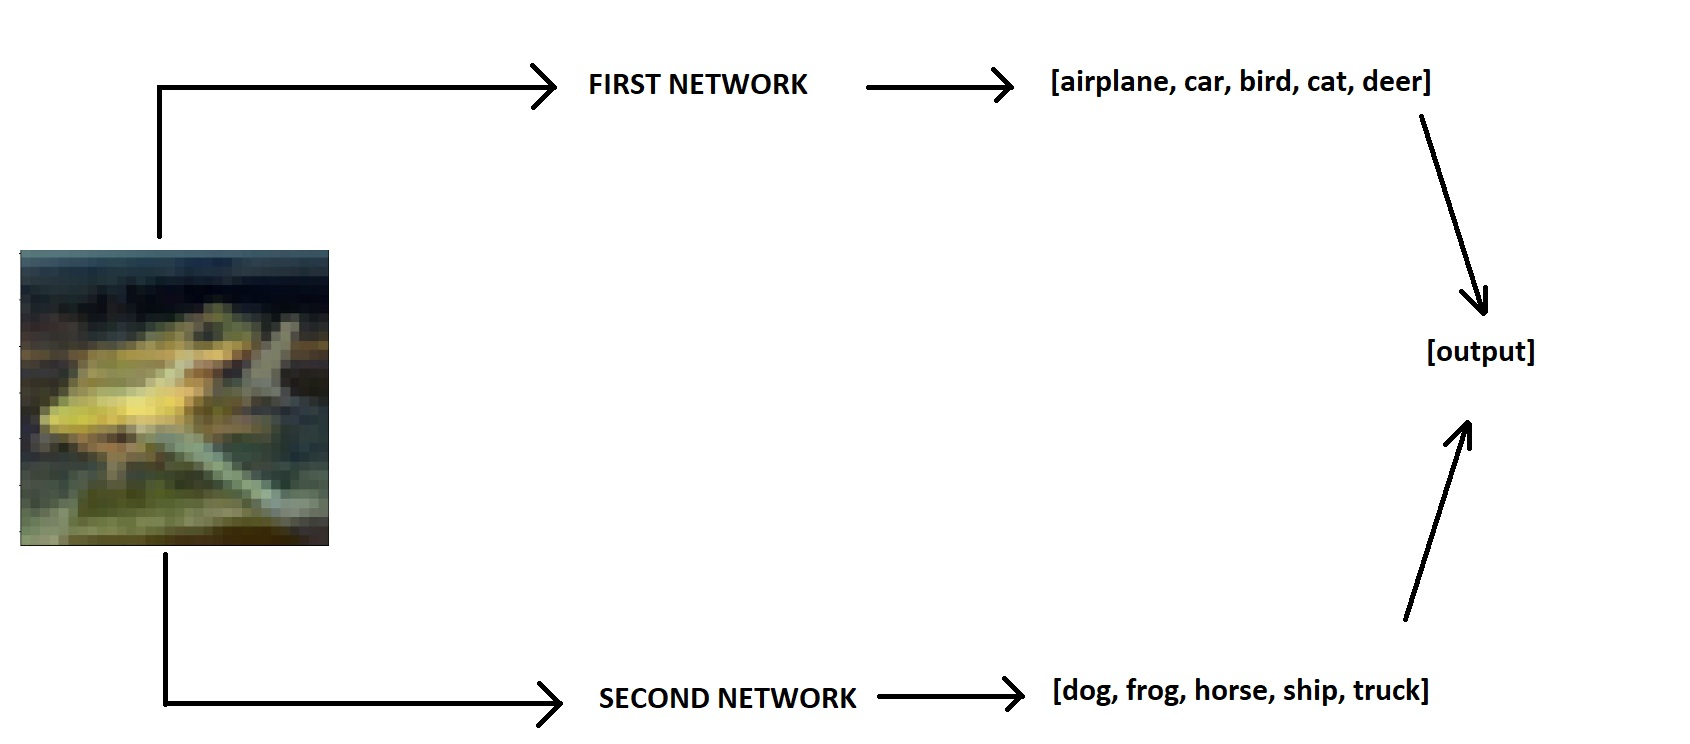

## LIBRARIES IMPORT

In [12]:
from tensorflow.keras import models, optimizers # Useful for our custom neural network architecture.
from tensorflow.keras.callbacks import EarlyStopping    # Useful callback during training phase.

## UTILITY FUNCTIONS
### my_custom_neural_network()
This function defines the architecture of the convolutional neural networks designed to classify the mixed images into 5 classes.

For what concern input and output:
* the network accepts images of size $32\times32\times32$, corresponding to the three-channel RGB coloured images in the CIFAR-10 dataset
* the network computes in output a probability array with 5 values (one for each expected class), obtained from the last dense layer with softmax activation.

The network consists of four main blocks, each with a similar structure that exploits convolution, normalisation, activation and pooling but with different parameters.

In particular the neural network architecture is composed by:
* convolution layers $\rightarrow$ each block starts with two levels of $3\times3$ convolution, followed by ReLU activation to extract relevant features from the image
* batch normalization layers $\rightarrow$ after each convolution, batch normalisation is applied to stabilise the training by improving learning speed and reducing sensitivity to initial values
* pooling layers $\rightarrow$ each block is followed by a $2\times2$ max pooling layer, which reduces the spatial size of the feature maps (height and width) by half.
* droput layers $\rightarrow$ dropout is applied to prevent overfitting, increasing the robustness of the model.

In [13]:
def my_custom_neural_network():
    """
    Defines a custom CNN architecture for  32x32x3 classification tasks. 
    The network is composed of multiple convolutional blocks, followed by fully connected layers 
    to predict the class probabilities.

    Returns:
        a TensorFlow Keras Model object representing the CNN.
    """
    input_layer = layers.Input(shape=(32, 32, 3))

    # First convolutional block.
    first_block_layer = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input_layer)
    first_block_layer = layers.BatchNormalization()(first_block_layer)
    first_block_layer = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(first_block_layer)
    first_block_layer = layers.BatchNormalization()(first_block_layer)
    first_block_layer = layers.MaxPooling2D((2, 2))(first_block_layer)
    first_block_layer = layers.Dropout(0.25)(first_block_layer)

    # Second convolutional block.
    second_block_layer = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(first_block_layer)
    second_block_layer = layers.BatchNormalization()(second_block_layer)
    second_block_layer = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(second_block_layer)
    second_block_layer = layers.BatchNormalization()(second_block_layer)
    second_block_layer = layers.MaxPooling2D((2, 2))(second_block_layer)
    second_block_layer = layers.Dropout(0.3)(second_block_layer)

    # Third convolutional block.
    third_block_layer = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(second_block_layer)
    third_block_layer = layers.BatchNormalization()(third_block_layer)
    third_block_layer = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(third_block_layer)
    third_block_layer = layers.BatchNormalization()(third_block_layer)
    third_block_layer = layers.MaxPooling2D((2, 2))(third_block_layer)
    third_block_layer = layers.Dropout(0.4)(third_block_layer)

    # Fourth convolutional block.
    fourth_block_layer = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(third_block_layer)
    fourth_block_layer = layers.BatchNormalization()(fourth_block_layer)
    fourth_block_layer = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(fourth_block_layer)
    fourth_block_layer = layers.BatchNormalization()(fourth_block_layer)
    fourth_block_layer = layers.GlobalAveragePooling2D()(fourth_block_layer)

    # Last dense block.
    last_block_layer = layers.Dense(512, activation="relu")(fourth_block_layer)
    last_block_layer = layers.Dropout(0.5)(last_block_layer)
    last_block_layer = layers.Dense(256, activation="relu")(last_block_layer)
    last_block_layer = layers.Dropout(0.5)(last_block_layer)

    output_layer = layers.Dense(5, activation="softmax")(last_block_layer)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

### Functions for monitoring training curves
* plot_training_curves() shows graphs relating to the training of a model, showing how loss and accuracy evolve over time, for both the training set and the validation set
* plot_validation_accuracies(), instead, compares the accuracy curves on validation set of two different models during training.

In [14]:
def plot_training_curves(training_history, model_name):
    """
    Plots the training and validation loss and accuracy curves produces by a given model.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(training_history.history['loss'], label='TRAINING LOSS')
    plt.plot(training_history.history['val_loss'], label='VALIDATION LOSS')
    plt.title(f'{model_name} - LOSS')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['accuracy'], label='TRAINING ACCURACY')
    plt.plot(training_history.history['val_accuracy'], label='VALIDATION ACCURACY')
    plt.title(f'{model_name} - ACCURACY')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_validation_accuracies(history_1, history_2):
    """
    Plots the comparison of validation accuracies between two models over training epochs.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history_1.history['val_accuracy'], label='FIRST MODEL VALIDATION ACCURACY')
    plt.plot(history_2.history['val_accuracy'], label='SECOND MODEL VALIDATION ACCURACY')
    plt.title("VALIDATION ACCURACY COMPARISON")
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.legend()
    plt.grid(True)
    plt.show()

## CUSTOM SPLITTING OF THE DATASET
By splitting the problem in two different parts, also the dataset splitting should be changed.

In particular, the goal of the following code is to start from the code provided by the teacher and split the dataset more in detail, taking into account not only the division between the two groups of different classes, but also separating each subgroup into training set, validation set and test set, to ensure that the model is trained on separate data for training, validation and testing phase.

To obtain a splitted dataset suitable for our networks: 
* splitting of the dataset according to the labels (y) $\rightarrow$ the first 5 classes of CIFAR-10 dataset are reserved for the first network, while the last 5 classes are reserved for the second network
* creation of separate sets for training, validation and testing $\rightarrow$ each network has a training set of size 20000, a validation set of size 5000 and a test set $\rightarrow$ these dimensions have been chosen experimentally
* each set consists of the patterns (x) and their corresponding labels (y).


In [15]:
# Dataset splitting for first network (first 5 classes).
cond_1_for_training_set = cifar10_y_train[:,0] < 5
# Training set.
training_x__for_first_net = cifar10_x_train[cond_1_for_training_set][:20000]
training_y_for_first_net = cifar10_y_train[cond_1_for_training_set][:20000]
# Validation set.
validation_x_for_first_net = cifar10_x_train[cond_1_for_training_set][20000:25000]
validation_y_for_first_net = cifar10_y_train[cond_1_for_training_set][20000:25000]
# Test set.
cond_1_for_test_set = cifar10_y_test[:,0] < 5
test_x_for_first_net = cifar10_x_test[cond_1_for_test_set]
test_y_for_first_net = cifar10_y_test[cond_1_for_test_set]

# Dataset splitting for second network (last 5 classes).
cond_2_for_training_set = cifar10_y_train[:,0] >= 5
# Training set.
training_x_for_second_net = cifar10_x_train[cond_2_for_training_set][:20000]
training_y_for_second_net = cifar10_y_train[cond_2_for_training_set][:20000]
# Validation set.
validation_x_for_second_net = cifar10_x_train[cond_2_for_training_set][20000:25000]
validation_y_for_second_net = cifar10_y_train[cond_2_for_training_set][20000:25000]
# Test set.
cond_2_for_test_set = cifar10_y_test[:,0] >= 5
test_x_for_second_net = cifar10_x_test[cond_2_for_test_set]
test_y_for_second_net = cifar10_y_test[cond_2_for_test_set]

## MIXED-DATA GENERATORS FOR THE NETWORKS
Also the datagenerator() function provided by the teacher should be changed accordingly with the new dataset splitting and taking into account that now it will be used in a slightly different way from the two networks, so it could be useful to define two different version of the original datagenerator() function:

* datagenerator for the first network $\rightarrow$ takes images of the first 5 classed and mix them with images of the last 5 classes (this is why the function should have the patterns x of both the first and the last 5 classes)
* datagenerator for the second network $\rightarrow$ works exactly as the previous one, but on the last 5 classes, mixing them with the first 5 classes.

In [16]:
def datagenerator_for_first_network(X1, X2, Y1, batchsize):
    """
    Data generator for the first network (class 0 to 4).
    
    This function is used to generate batches of data that are used for training 
    the first neural network. 
    """
    size1 = X1.shape[0]
    Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)

    while True:
        num1 = np.random.randint(0, size1, batchsize)
        num2 = np.random.randint(0, X2.shape[0], batchsize)
        x_data = (X1[num1] + X2[num2]) / 2.0
        y_data = Y1_cat[num1]
        yield x_data, y_data

def datagenerator_for_second_network(X1, X2, Y2, batchsize):
    """
    Data generator for the second network (class 5 to 9).
    
    This function is used to generate batches of data that are used for training 
    the second neural network. 
    """
    size2 = X2.shape[0]
    Y2_cat = tf.keras.utils.to_categorical(Y2 - 5, num_classes=5)

    while True:
        num1 = np.random.randint(0, X1.shape[0], batchsize)
        num2 = np.random.randint(0, size2, batchsize)
        x_data = (X1[num1] + X2[num2]) / 2.0
        y_data = Y2_cat[num2]
        yield x_data, y_data

## DATASET CREATION WITH MIXED-DATA

The following code exploits the two functions above and the dataset splitted earlier to produce the final version of the sets, the ones that will be used for the training of the two neural networks.

Note that:
* for the training and validation sets are used my custom functions to generate the mixed images
* for the testing set is used the function defined by the teacher.

In [17]:
batch_size = 8

# Training dataset generation for the first network.
training_generator_for_first_network = datagenerator_for_first_network(training_x__for_first_net, training_x_for_second_net, training_y_for_first_net, batch_size)
validation_generator_for_first_network = datagenerator_for_first_network(validation_x_for_first_net, validation_x_for_second_net, validation_y_for_first_net, batch_size)

# Training dataset generation for the second network.
training_generator_for_second_network = datagenerator_for_second_network(training_x__for_first_net, training_x_for_second_net, training_y_for_second_net, batch_size)
validation_generator_for_second_network = datagenerator_for_second_network(validation_x_for_first_net, validation_x_for_second_net, validation_y_for_second_net, batch_size)

# Testing dataset generation for both network, using the function provided by the teacher.
testgen = datagenerator(test_x_for_first_net, test_x_for_second_net, test_y_for_first_net, test_y_for_second_net, 10000)

## MODELS CREATION
The following code:
* creates the two models using for both the same neural network architecture defined at the beginning of the presentation of this solution
* shows a summary of the structure of the first network (the second is the same), including informations about the different layers of the network and the number of parameters
* compiles the two models exploiting the Adam optimizer (that adapts tha learning speed during the training) and the categorical cross-entropy as loss function.


In [18]:
first_network = my_custom_neural_network()
second_network = my_custom_neural_network()

first_network.summary()

first_network.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
second_network.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,088,325 (19.41 MB)

 Trainable params: 5,084,485 (19.40 MB)

 Non-trainable params: 3,840 (15.00 KB)

## DEFINITION OF TRAINING HYPERPARAMETERS
The following code contains the various hyperparameters that impact on the training process, including:
* number of epochs
* training steps per epoch and validation steps per epoch $\rightarrow$ these hyperparameters defines how many batch size of images the model sees during an epoch and typically (in a typical problem) $stepsPerEpoch=\frac{training\_set\_size}{batch\_size}$, so that during each epoch the model is able to see every pattern that is included in the training set, but in this case we have a sort of dynamic dataset as the number of all the possible combinations between images from the two groups is very large, so this hyperparameter can be chosen experimentally
* earlystopping callbacks $\rightarrow$ mechanism that stops the training of the model if the monitored metric (in this case the validation accuracy) stops increasing for a number of consecutive epochs defined by the patience parameter.

Note that the value of all these hyperparameters (including the batch_size defined above) has been discovered experimentally.

In [19]:
number_of_epochs = 3
training_steps_per_epoch = 100
validation_steps_per_epoch = 10

early_stopping_for_first_network = EarlyStopping(monitor='val_accuracy', mode="max", patience=10, restore_best_weights=True)
early_stopping_for_second_network = EarlyStopping(monitor='val_accuracy', mode="max", patience=10, restore_best_weights=True)

## TRAINING PHASE OF THE FIRST NETWORK

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.2297 - loss: 2.1505 - val_accuracy: 0.1500 - val_loss: 2.0559
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2393 - loss: 1.9006 - val_accuracy: 0.2625 - val_loss: 1.5903
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.2304 - loss: 1.7287 - val_accuracy: 0.1875 - val_loss: 2.5187


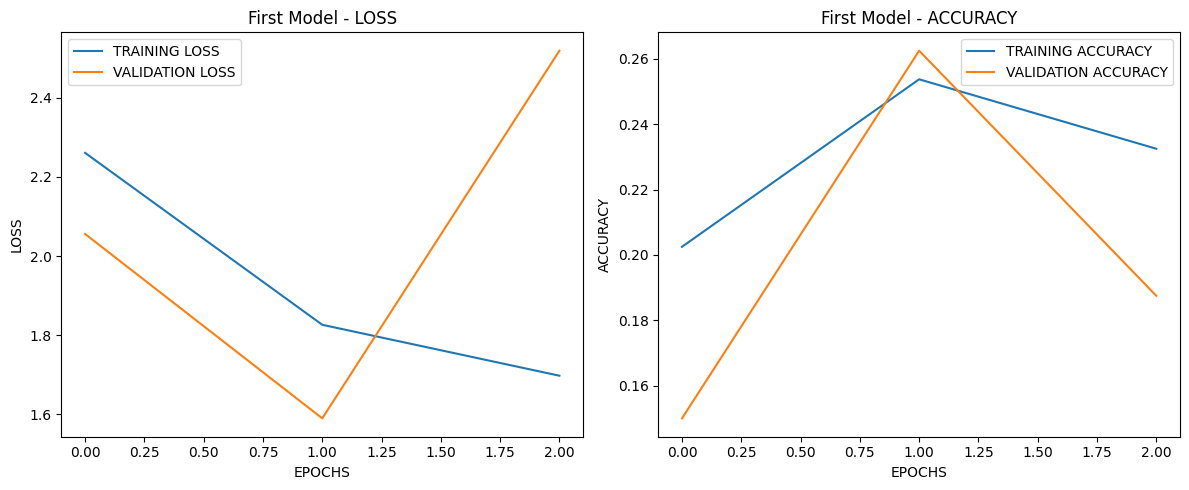

In [20]:
first_network_history = first_network.fit(
    training_generator_for_first_network,
    steps_per_epoch=training_steps_per_epoch,
    epochs=number_of_epochs,
    validation_data=validation_generator_for_first_network,
    validation_steps=validation_steps_per_epoch,
    callbacks=early_stopping_for_first_network
)

plot_training_curves(first_network_history, "First Model")

## TRAINING PHASE OF THE SECOND NETWORK

Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.2341 - loss: 2.1524 - val_accuracy: 0.2125 - val_loss: 2.6374
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.2399 - loss: 1.8493 - val_accuracy: 0.2750 - val_loss: 1.6453
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.2965 - loss: 1.6561 - val_accuracy: 0.2625 - val_loss: 1.7401


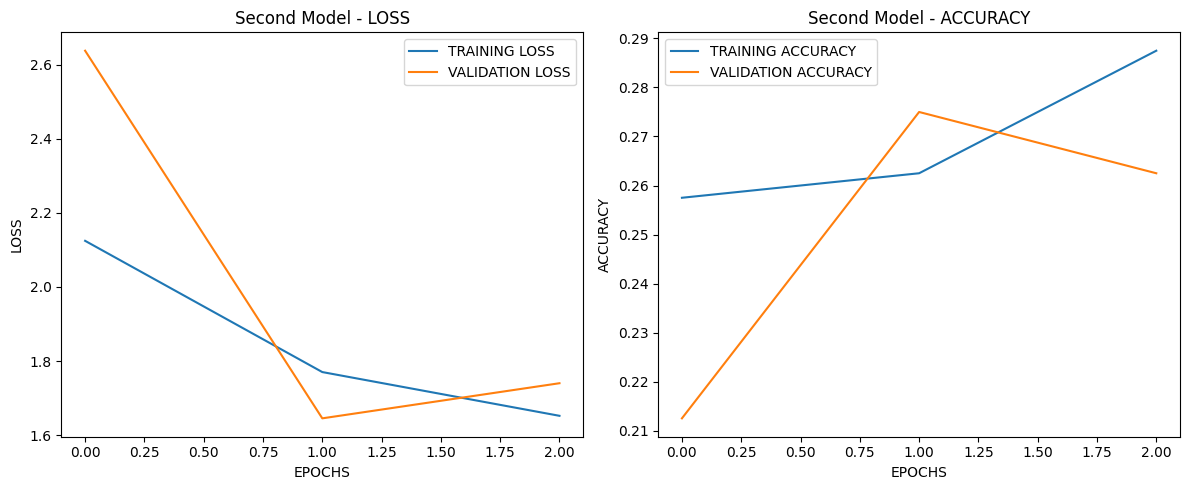

In [21]:
second_network_history = second_network.fit(
    training_generator_for_second_network,
    steps_per_epoch=training_steps_per_epoch,
    epochs=number_of_epochs,
    validation_data=validation_generator_for_second_network,
    validation_steps=validation_steps_per_epoch,
    callbacks=early_stopping_for_second_network
)

plot_training_curves(second_network_history, "Second Model")

## WEIGHTS SAVING
As requested by the teacher, the weights of the models must be saved.

In [22]:
first_network.save_weights('model_1.weights.h5')
second_network.save_weights('model_2.weights.h5')

## TRAINING COMPARISON
The following function shows the curves of the validation accuracy produced by the two models, allowing us to make some considerations: as the curves show, the first model is always less precise than the second one.

I tried to regularize this aspect exploiting data augmentation techniques and/or preprocessing mechanism (only for the first 5 classes of the dataset) but it didn't work (sometimes it even decrease significantly the performance of the first model), so I suppose it can be defined an intrinsec problem of the dataset: it is harder to classify the first 5 classes than the last 5 classes, maybe due to variance class imbalance (maybe the last 5 classes show better variance and variability of their pattern than the first 5 classes).

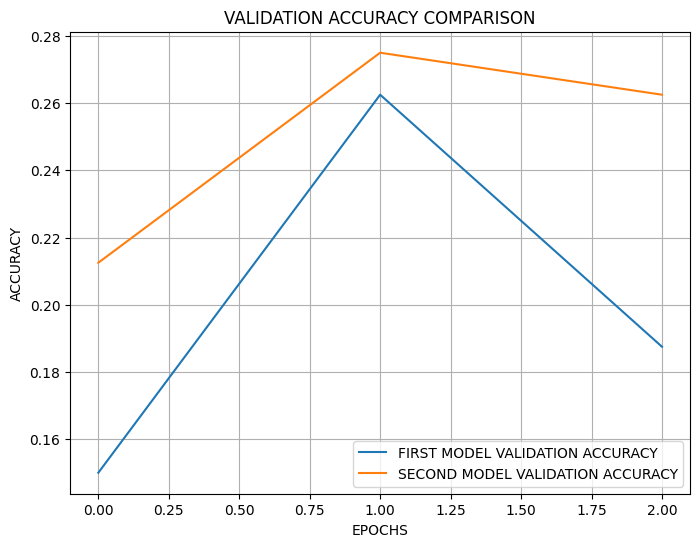

In [23]:
plot_validation_accuracies(first_network_history, second_network_history)

## MODELS EVALUATION ON TEST SET
The goal of the following code is to evaluate the performance of the two models on the test set.

Note that also in this case the function has been slightly modified with respect to the one provided by the teacher, as in this case we have two models to evaluate by combining their oputputs, not a single model.

In [24]:
def eval_models(model_1, model_2):
    eval_samples_x, eval_samples_y = next(testgen)

    # Predictions.
    guess_1 = model_1.predict(eval_samples_x)
    guess_2 = model_2.predict(eval_samples_x)

    correct_1 = np.argmax(guess_1, axis=1) == np.argmax(eval_samples_y[0], axis=1)
    accuracy_1 = np.mean(correct_1)

    correct_2 = np.argmax(guess_2, axis=1) == np.argmax(eval_samples_y[1], axis=1)
    accuracy_2 = np.mean(correct_2)

    return (accuracy_1 + accuracy_2) / 2

repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_models(first_network, second_network))

print("MEAN ACCURACY ON TEST SET: ", np.mean(eval_results))
print("STANDARD DEVIATION ON TEST SET: ", np.std(eval_results))


313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step
MEAN ACCURACY ON TEST SET:  0.23772500000000002
STANDARD DEVIATION ON TEST SET:  0.0021045486451968733


## CONCLUSIONS
As the evaluation results shows, the model is quite accurate, precise and robust.

As proof of the robustness of the proposed solution it is important to underline that during the various and different experiments made the mean of the accuracies of the single networks has always been above 80%, even changing important hyperparameters such as learning rate, patience, steps per epoch..., and this is a sign of robustness.

Surely it should be explored why the first model is always slightly worse than the second one, but as previously said it could be a small defect on the variance of the dataset.

To sum up, in any case the proposed solution, considering also the performance of the random model on the test set, represents an acceptable, accurate and robust deep learning algorithm to solve the problem of classifying mixed images on the CIFAR10 dataset.